# Satellite SR 

## DE

In [1]:
import os
import rasterio
import matplotlib.pyplot as plt
import math

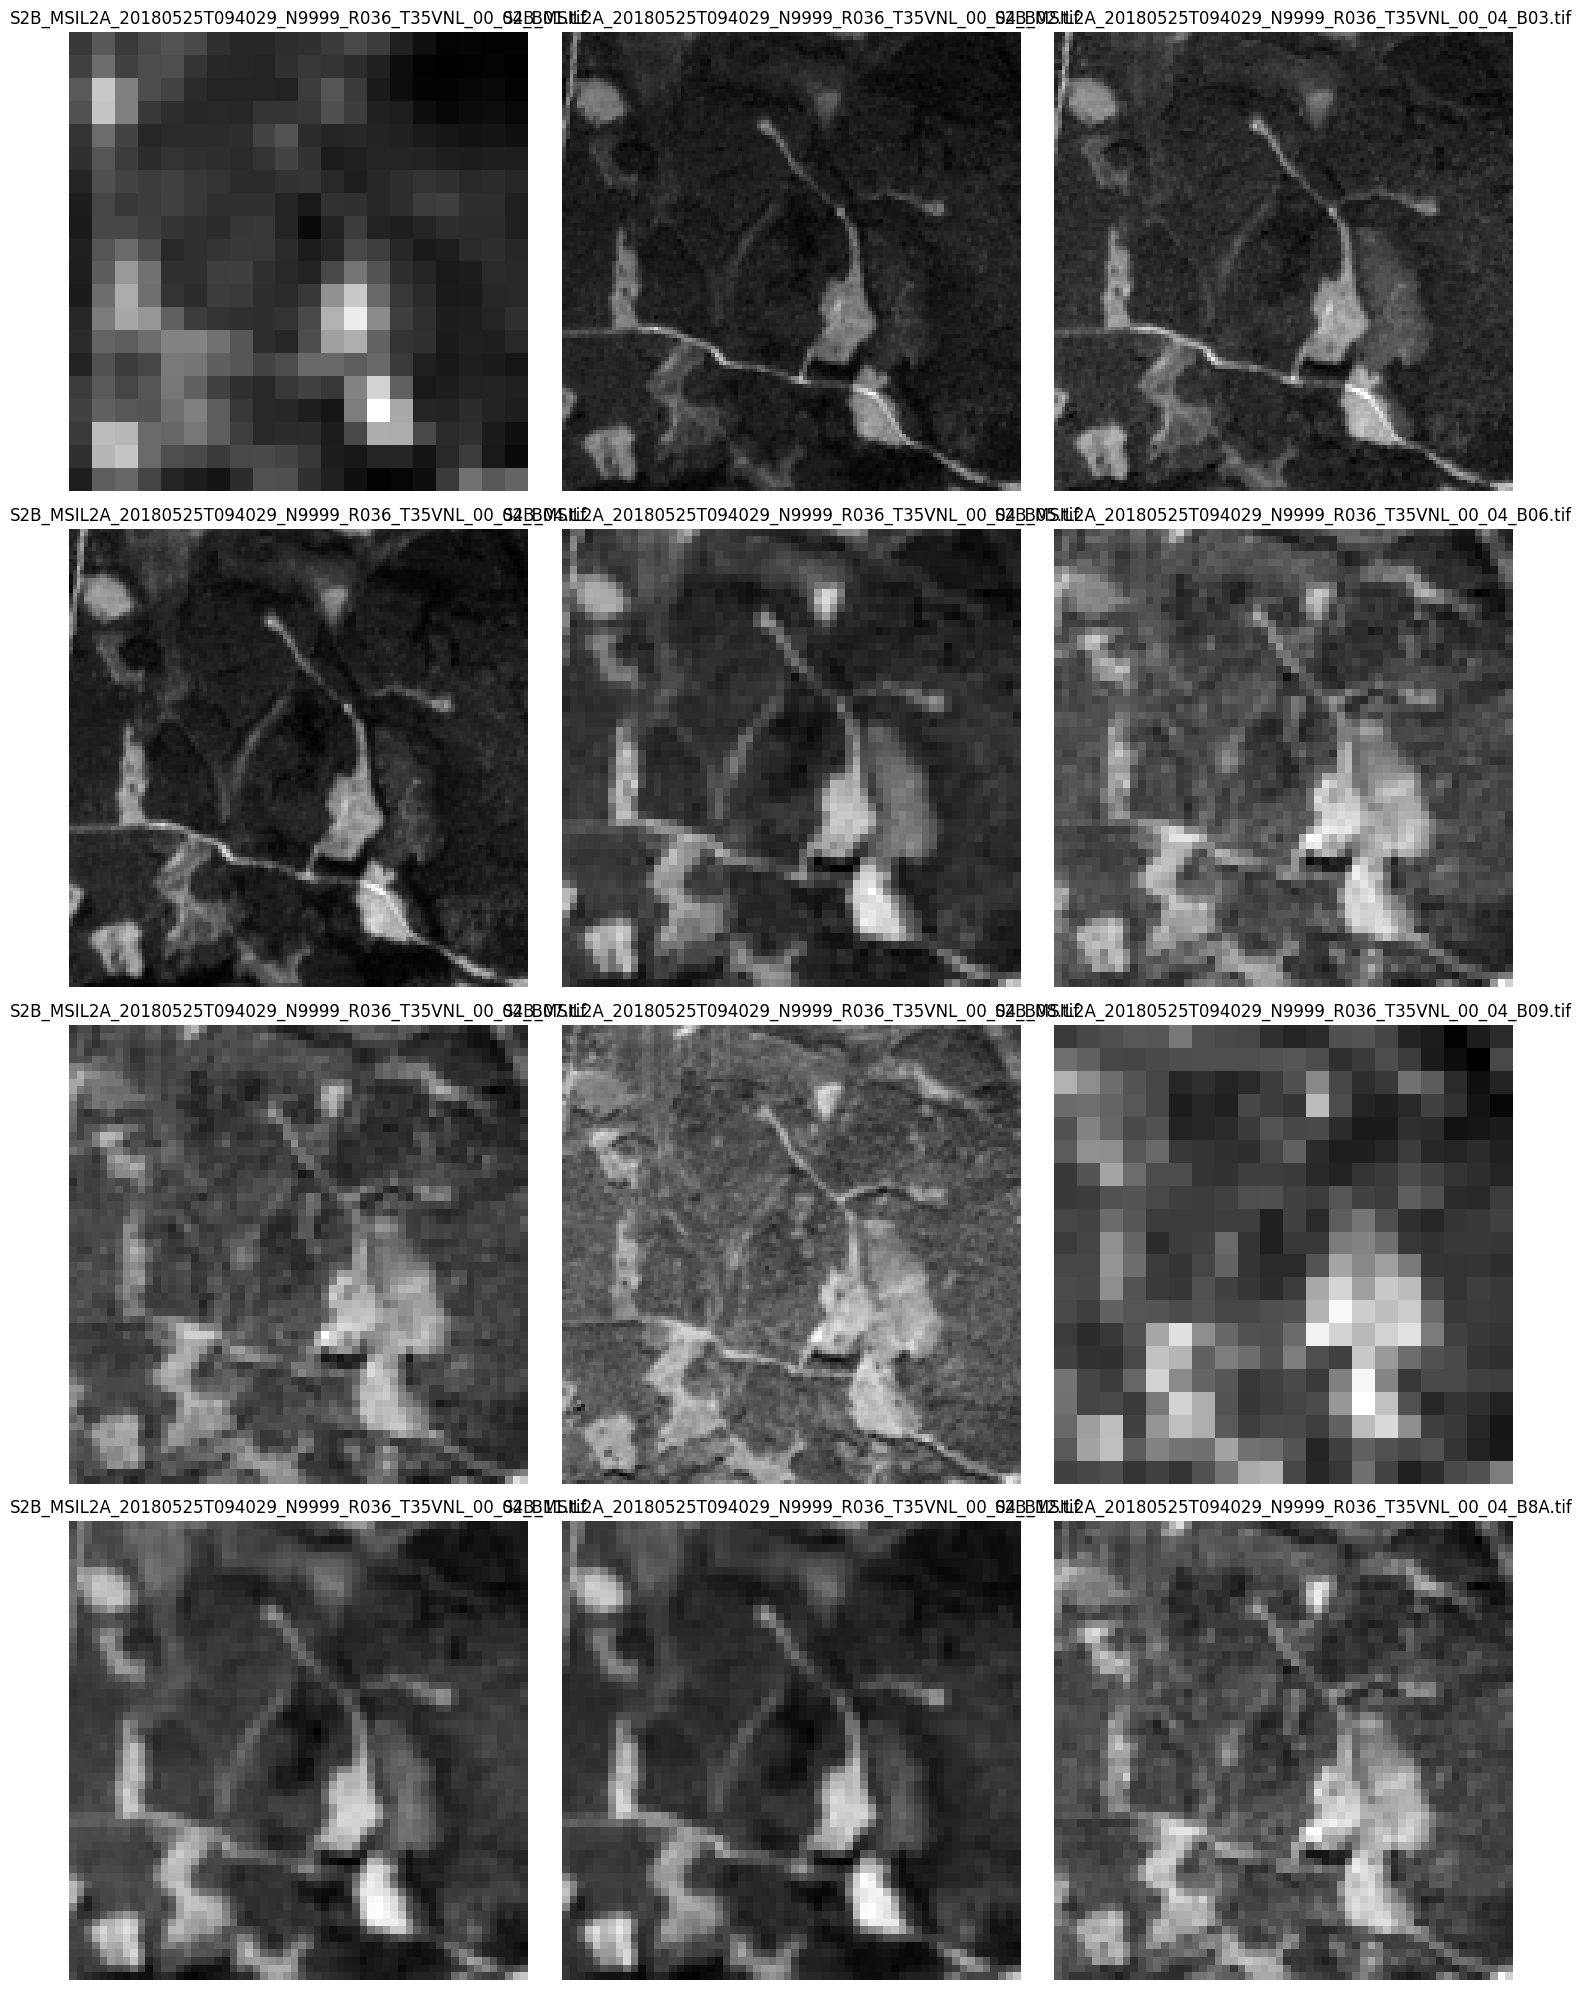

In [2]:
datasetPath = r"C:\Datasets\Sample\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_04"
imagePaths = [f for f in os.listdir(datasetPath) if f.endswith('.tif')]

## Visualisation
num_images = len(imagePaths)
cols = 3  
rows = math.ceil(num_images / cols)  

fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))
axs = axs.flatten()

for i, image in enumerate(imagePaths):
    imagePath = os.path.join(datasetPath, image)
    with rasterio.open(imagePath) as src:
        img = src.read()

        if img.shape[0] >= 3:
            axs[i].imshow(img[:3].transpose((1, 2, 0)))
        else:
            axs[i].imshow(img[0], cmap='gray')
            
        axs[i].set_title(image)
        axs[i].axis('off')


for j in range(i + 1, len(axs)): # hiding any unused subplots if uneven number of images
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


## DP

In [1]:
import os
import rasterio
import numpy as np
import torch
from skimage.transform import resize
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import rasterio
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datasetPath = r"C:\Datasets\Sample"

imagePaths, data = [], []

for root, dirs, files in os.walk(datasetPath):
    for dir in dirs:
        for root, dirs, files in os.walk(os.path.join(datasetPath, dir)):
            for file in files:
                image_path = os.path.join(datasetPath, dir, file)
                imagePaths.append(image_path)
                print(image_path)

C:\Datasets\Sample\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00_B01.tif
C:\Datasets\Sample\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00_B02.tif
C:\Datasets\Sample\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00_B03.tif
C:\Datasets\Sample\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00_B04.tif
C:\Datasets\Sample\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00_B05.tif
C:\Datasets\Sample\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00_B06.tif
C:\Datasets\Sample\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00_B07.tif
C:\Datasets\Sample\S2B_MSIL2A_20180525T094029_N9999_R036_T35VNL_00_00\S2B_MSIL2A_20180525T094029_

LR shape: torch.Size([4, 1, 56, 56]), HR shape: torch.Size([4, 1, 112, 112])


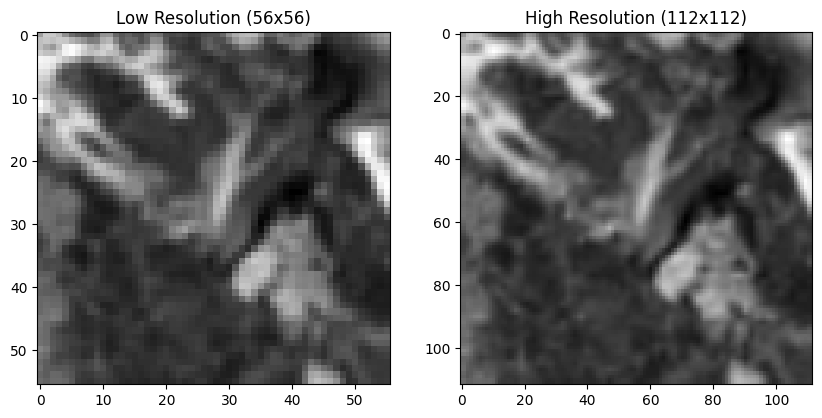

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class SRDataset(Dataset):
    def __init__(self, data_paths):
        self.data_paths = data_paths

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        image_path = self.data_paths[idx]
        with rasterio.open(image_path) as src:
            img = src.read(1)

            hr_img = resize(img, (112, 112), anti_aliasing=True, preserve_range=True)
            lr_img = resize(hr_img, (56, 56), anti_aliasing=True, preserve_range=True) # currently just downsampling by 2x

            lr_img = lr_img / 255.0
            hr_img = hr_img / 255.0

            lr_tensor = torch.tensor(lr_img, dtype=torch.float32).unsqueeze(0)  # [1, 56, 56]
            hr_tensor = torch.tensor(hr_img, dtype=torch.float32).unsqueeze(0)  # [1, 112, 112]

        return lr_tensor, hr_tensor

data_paths = imagePaths
dataset = SRDataset(data_paths)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr, hr in dataloader:
    lr, hr = lr.to(device), hr.to(device)
    print(f"LR shape: {lr.shape}, HR shape: {hr.shape}")
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(lr[0, 0].cpu().numpy(), cmap='gray')
    plt.title("Low Resolution (56x56)")

    plt.subplot(1, 2, 2)
    plt.imshow(hr[0, 0].cpu().numpy(), cmap='gray')
    plt.title("High Resolution (112x112)")

    plt.show()
    break

## Model

### Pretrained

In [11]:
import torch
from transformers import Swin2SRImageProcessor, Swin2SRForImageSuperResolution
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Initialize the model and processor
processor = Swin2SRImageProcessor.from_pretrained("caidas/swin2SR-classical-sr-x2-64")

# try load
'''
try:
    model = Swin2SRForImageSuperResolution.from_pretrained("fine_tuned_swin2sr")
except:
    print("Model not found, training from scratch")
    '''
model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x2-64")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Swin2SRForImageSuperResolution(
  (swin2sr): Swin2SRModel(
    (first_convolution): Conv2d(3, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (embeddings): Swin2SREmbeddings(
      (patch_embeddings): Swin2SRPatchEmbeddings(
        (projection): Conv2d(180, 180, kernel_size=(1, 1), stride=(1, 1))
        (layernorm): LayerNorm((180,), eps=1e-05, elementwise_affine=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swin2SREncoder(
      (stages): ModuleList(
        (0-5): 6 x Swin2SRStage(
          (layers): ModuleList(
            (0-5): 6 x Swin2SRLayer(
              (attention): Swin2SRAttention(
                (self): Swin2SRSelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=6, bias=False)
                  )
                  (que

### Loss

In [5]:
criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-4)

## Training

In [8]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (lr_tensor, hr_tensor) in enumerate(progress_bar):
        lr_tensor, hr_tensor = lr_tensor.to(device), hr_tensor.to(device)

        optimizer.zero_grad()
        inputs = {'pixel_values': lr_tensor}
        outputs = model(**inputs)
        sr_image = outputs.reconstruction

        # Compute loss
        loss = criterion(sr_image, hr_tensor)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        if epoch % 5 == 0:
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(lr_tensor[0, 0].cpu().numpy(), cmap='gray')
            plt.title("Low-Resolution Input")

            plt.subplot(1, 2, 2)
            plt.imshow(sr_image[0, 0].cpu().detach().numpy(), cmap='gray')
            plt.title("Super-Resolved Output")

            plt.show()

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss/len(dataloader):.4f}")

model.save_pretrained("fine_tuned_swin2sr")

# load model


Epoch 1/20:   0%|          | 0/15 [00:00<?, ?it/s]c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 112, 112])) that is different to the input size (torch.Size([4, 3, 112, 112])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### Eval

In [15]:
try:
    #torch.load("fine_tuned_swin2sr")
    model = Swin2SRForImageSuperResolution.from_pretrained("fine_tuned_swin2sr")
    model.to(device)
except:
    print("Model not found")

In [16]:
model.eval()
with torch.no_grad():
    eval_loss = 0.0
    for lr_tensor, hr_tensor in tqdm(dataloader, desc="Evaluating"):
        lr_tensor, hr_tensor = lr_tensor.to(device), hr_tensor.to(device)
        inputs = {'pixel_values': lr_tensor}
        outputs = model(**inputs)
        sr_image = outputs.reconstruction
        loss = criterion(sr_image, hr_tensor)
        eval_loss += loss.item()

print(f"Evaluation Loss: {eval_loss/len(dataloader):.4f}")


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 112, 112])) that is different to the input size (torch.Size([4, 3, 112, 112])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Evaluating: 100%|██████████| 15/15 [00:02<00:00,  5.47it/s]

Evaluation Loss: 0.0123


### Testing

In [17]:
test_dataset = SRDataset(data_paths)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Evaluating on Test Data:   0%|          | 0/60 [00:00<?, ?it/s]c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 112, 112])) that is different to the input size (torch.Size([1, 3, 112, 112])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


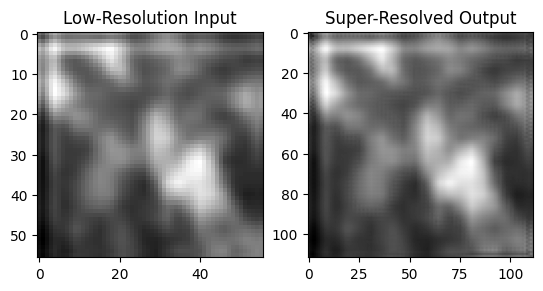

Evaluating on Test Data:  15%|█▌        | 9/60 [00:00<00:04, 12.28it/s]

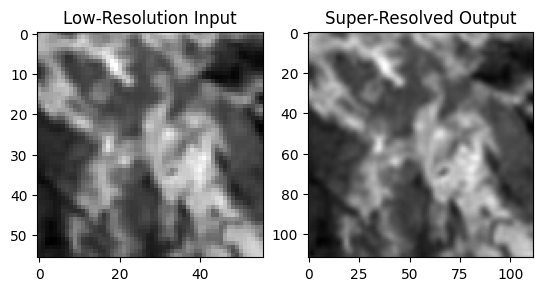

Evaluating on Test Data:  32%|███▏      | 19/60 [00:01<00:02, 16.65it/s]

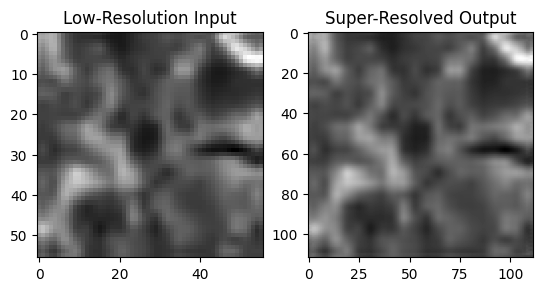

Evaluating on Test Data:  48%|████▊     | 29/60 [00:02<00:01, 15.72it/s]

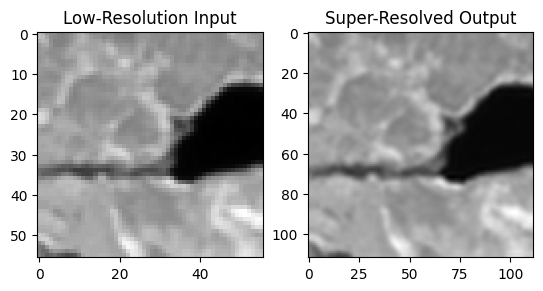

Evaluating on Test Data:  65%|██████▌   | 39/60 [00:03<00:01, 14.31it/s]

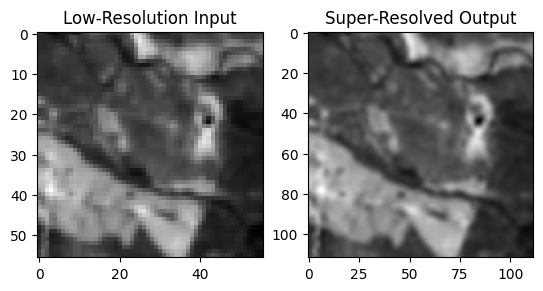

Evaluating on Test Data:  82%|████████▏ | 49/60 [00:03<00:00, 14.50it/s]

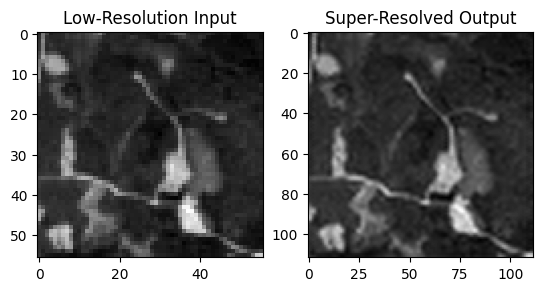

Evaluating on Test Data: 100%|██████████| 60/60 [00:04<00:00, 13.04it/s]

Test Dataset Evaluation Loss: 0.0123


In [19]:
# Evaluation on Test Dataset
model.eval()
with torch.no_grad():
    eval_loss = 0.0
    i = 0
    for lr_tensor, hr_tensor in tqdm(test_dataloader, desc="Evaluating on Test Data"):
        lr_tensor, hr_tensor = lr_tensor.to(device), hr_tensor.to(device)
        inputs = {'pixel_values': lr_tensor}
        outputs = model(**inputs)
        sr_image = outputs.reconstruction
        loss = criterion(sr_image, hr_tensor)
        eval_loss += loss.item()


        if i % 10 == 0:
            plt.subplot(1, 2, 1)
            plt.imshow(lr_tensor[0, 0].cpu().numpy(), cmap='gray')
            plt.title("Low-Resolution Input")

            plt.subplot(1, 2, 2)
            plt.imshow(sr_image[0, 0].cpu().detach().numpy(), cmap='gray')
            plt.title("Super-Resolved Output")

            plt.show()

        i += 1

print(f"Test Dataset Evaluation Loss: {eval_loss/len(test_dataloader):.4f}")
